In [63]:
import deepforest
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
import numpy as np
from deepforest import CascadeForestClassifier
from importlib import reload
from sklearn.ensemble import RandomForestClassifier


In [61]:
#reload(deepforest)

<module 'deepforest' from 'C:\\Users\\varsh\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\deepforest\\__init__.py'>

In [2]:
def store_results(model_name, y_test, y_pred, params):
    # Create a DataFrame for the results of this model run
    results = pd.DataFrame({
        'Model': [model_name],
        'Parameters': [params],  # Ensure params are formatted correctly for DataFrame storage
        'Accuracy': [accuracy_score(y_test, y_pred)],
        'Precision': [precision_score(y_test, y_pred, average='weighted')],
        'Recall': [recall_score(y_test, y_pred, average='weighted')],
        'F1-Score': [f1_score(y_test, y_pred, average='weighted')],
        'AUC-ROC': [roc_auc_score(y_test, y_pred)]
    })
    return results

In [3]:
telco_data_path = 'Datasets/telco_customer_churn/WA_Fn-UseC_-Telco-Customer-Churn.csv'
telco_data = pd.read_csv(telco_data_path)
telco_data_info = telco_data.info()
telco_data_head = telco_data.head()

telco_data_info, telco_data_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


(None,
    customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
 0  7590-VHVEG  Female              0     Yes         No       1           No   
 1  5575-GNVDE    Male              0      No         No      34          Yes   
 2  3668-QPYBK    Male              0      No         No       2          Yes   
 3  7795-CFOCW    Male              0      No         No      45           No   
 4  9237-HQITU  Female              0      No         No       2          Yes   
 
       MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
 0  No phone service             DSL             No  ...               No   
 1                No             DSL            Yes  ...              Yes   
 2                No             DSL            Yes  ...               No   
 3  No phone service             DSL            Yes  ...              Yes   
 4                No     Fiber optic             No  ...               No   
 
   TechSupport StreamingTV StreamingMovie

In [4]:
# Attempt to convert 'TotalCharges' to numeric type, forcing errors to be NaN so we can identify them
telco_data['TotalCharges'] = pd.to_numeric(telco_data['TotalCharges'], errors='coerce')
missing_total_charges = telco_data['TotalCharges'].isna().sum()

invalid_total_charges_rows = telco_data[telco_data['TotalCharges'].isna()]
missing_total_charges, invalid_total_charges_rows.head()

(11,
       customerID  gender  SeniorCitizen Partner Dependents  tenure  \
 488   4472-LVYGI  Female              0     Yes        Yes       0   
 753   3115-CZMZD    Male              0      No        Yes       0   
 936   5709-LVOEQ  Female              0     Yes        Yes       0   
 1082  4367-NUYAO    Male              0     Yes        Yes       0   
 1340  1371-DWPAZ  Female              0     Yes        Yes       0   
 
      PhoneService     MultipleLines InternetService       OnlineSecurity  ...  \
 488            No  No phone service             DSL                  Yes  ...   
 753           Yes                No              No  No internet service  ...   
 936           Yes                No             DSL                  Yes  ...   
 1082          Yes               Yes              No  No internet service  ...   
 1340           No  No phone service             DSL                  Yes  ...   
 
          DeviceProtection          TechSupport          StreamingTV  \
 

In [5]:
# Re-attempt to fill missing TotalCharges with 0 and verify if any missing values still exist in the dataset
telco_data['TotalCharges'].fillna(0, inplace=True)
missing_values_after_filling = telco_data.isna().sum()

# Attempt again to encode categorical variables
categorical_columns = telco_data.select_dtypes(include=['object']).columns.drop('customerID')  # Exclude customerID
telco_data_encoded = pd.get_dummies(telco_data, columns=categorical_columns, drop_first=True)  # One-hot encoding

# Show a snippet of the newly encoded dataframe and check for any remaining missing values
telco_data_encoded.head()
missing_values_after_filling

C:\Users\varsh\AppData\Local\Temp\ipykernel_18716\1266531264.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  telco_data['TotalCharges'].fillna(0, inplace=True)


customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [6]:
telco_data['tenure_group'] = pd.cut(telco_data['tenure'], bins=[0, 12, 24, 36, 48, 60, 72], labels=['0-12', '13-24', '25-36', '37-48', '49-60', '61-72'])
telco_data['monthly_charges_group'] = pd.cut(telco_data['MonthlyCharges'], bins=[0, 20, 40, 60, 80, 100, 120], labels=['0-20', '21-40', '41-60', '61-80', '81-100', '101-120'])

telco_data[['tenure_group', 'monthly_charges_group']].head()

,tenure_group,monthly_charges_group
0,0-12,21-40
1,25-36,41-60
2,0-12,41-60
3,37-48,41-60
4,0-12,61-80


In [7]:
# Scaling tenure and monthly charges columns
scaler = StandardScaler()
telco_data[['tenure', 'MonthlyCharges']] = scaler.fit_transform(telco_data[['tenure', 'MonthlyCharges']])

telco_data[['tenure', 'MonthlyCharges']].head()

,tenure,MonthlyCharges
0,-1.277445,-1.160323
1,0.066327,-0.259629
2,-1.236724,-0.362660
3,0.514251,-0.746535
4,-1.236724,0.197365


In [8]:
telco_data_encoded = pd.get_dummies(telco_data, columns=['gender', 'Partner', 'Dependents', 'PhoneService', 
                                                         'MultipleLines', 'InternetService', 'OnlineSecurity', 
                                                         'OnlineBackup', 'DeviceProtection', 'TechSupport', 
                                                         'StreamingTV', 'StreamingMovies', 'Contract', 
                                                         'PaperlessBilling', 'PaymentMethod'],
                                    drop_first=True)  # drop_first to avoid dummy variable trap

# Check the new DataFrame structure
print(telco_data_encoded.head())

   customerID  SeniorCitizen    tenure  MonthlyCharges  TotalCharges Churn  \
0  7590-VHVEG              0 -1.277445       -1.160323         29.85    No   
1  5575-GNVDE              0  0.066327       -0.259629       1889.50    No   
2  3668-QPYBK              0 -1.236724       -0.362660        108.15   Yes   
3  7795-CFOCW              0  0.514251       -0.746535       1840.75    No   
4  9237-HQITU              0 -1.236724        0.197365        151.65   Yes   

  tenure_group monthly_charges_group  gender_Male  Partner_Yes  ...  \
0         0-12                 21-40        False         True  ...   
1        25-36                 41-60         True        False  ...   
2         0-12                 41-60         True        False  ...   
3        37-48                 41-60         True        False  ...   
4         0-12                 61-80        False        False  ...   

   StreamingTV_No internet service  StreamingTV_Yes  \
0                            False            Fal

In [9]:
telco_data_encoded['tenure_group'] = telco_data_encoded['tenure_group'].cat.codes
telco_data_encoded['monthly_charges_group'] = telco_data_encoded['monthly_charges_group'].cat.codes
telco_data_encoded[['tenure_group', 'monthly_charges_group']].head()

,tenure_group,monthly_charges_group
0,0,1
1,2,2
2,0,2
3,3,2
4,0,3


In [10]:
telco_data_encoded = telco_data_encoded.drop(columns=['customerID'])
telco_data_encoded.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,tenure_group,monthly_charges_group,gender_Male,Partner_Yes,Dependents_Yes,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,-1.277445,-1.160323,29.85,No,0,1,False,True,False,...,False,False,False,False,False,False,True,False,True,False
1,0,0.066327,-0.259629,1889.50,No,2,2,True,False,False,...,False,False,False,False,True,False,False,False,False,True
2,0,-1.236724,-0.362660,108.15,Yes,0,2,True,False,False,...,False,False,False,False,False,False,True,False,False,True
3,0,0.514251,-0.746535,1840.75,No,3,2,True,False,False,...,False,False,False,False,True,False,False,False,False,False
4,0,-1.236724,0.197365,151.65,Yes,0,3,False,False,False,...,False,False,False,False,False,False,True,False,True,False


In [11]:
X = telco_data_encoded.drop(columns=['Churn'])
y = telco_data_encoded['Churn'].map({'Yes': 1, 'No': 0}) 

#RFE with scikit-learn's RFECV
model = LogisticRegression(max_iter=5000)
rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(5), scoring='accuracy')
rfecv.fit(X, y)
print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 27


In [12]:
selected_features = X.columns[rfecv.support_]
print("Selected features:", selected_features.tolist())

Selected features: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'tenure_group', 'monthly_charges_group', 'Dependents_Yes', 'PhoneService_Yes', 'MultipleLines_No phone service', 'MultipleLines_Yes', 'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_No internet service', 'OnlineSecurity_Yes', 'OnlineBackup_No internet service', 'OnlineBackup_Yes', 'DeviceProtection_No internet service', 'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No internet service', 'StreamingTV_Yes', 'StreamingMovies_No internet service', 'StreamingMovies_Yes', 'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check']


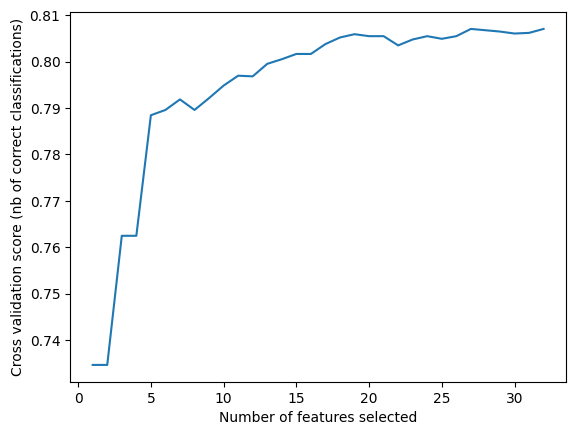

In [13]:
# Number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.show()

In [14]:
X_selected = X[selected_features]
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=100)

In [15]:
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Example: Training an XGBoost model with the selected features
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.05)
xgb_model.fit(X_train_selected, y_train)  # Training with selected features

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [16]:
results_df = pd.DataFrame(columns=['Model', 'Parameters', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC'])

In [17]:
n_estimators_grid = [50, 100, 150]
learning_rate_grid = [0.01, 0.05, 0.1]
max_depth_grid = [3, 5, 7]

In [18]:
for n_estimators in n_estimators_grid:
    for learning_rate in learning_rate_grid:
        for max_depth in max_depth_grid:
            # Define the model with the current set of hyperparameters
            model = XGBClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth)
            
            # Fitting the models ( give this some time)
            model.fit(X_train, y_train)
            
            # Predict on the test set
            y_pred = model.predict(X_test)
            
            # model evalation! give this some time
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='weighted')
            recall = recall_score(y_test, y_pred, average='weighted')
            f1 = f1_score(y_test, y_pred, average='weighted')
            auc_roc = roc_auc_score(y_test, y_pred)
            
            results = pd.DataFrame({
                'Model': ['XGBoost'],
                'Parameters': [f"n_estimators={n_estimators}, lr={learning_rate}, depth={max_depth}"],
                'Accuracy': [accuracy],
                'Precision': [precision],
                'Recall': [recall],
                'F1-Score': [f1],
                'AUC-ROC': [auc_roc]
            })
            
            # Append results to the DataFrame
            results_df = pd.concat([results_df, results], ignore_index=True)

C:\Users\varsh\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\varsh\AppData\Local\Temp\ipykernel_18716\675487804.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, results], ignore_index=True)


In [19]:
#results_df.to_csv('xgboost_hyperparameter_tuning_results.csv', index=False)

#print("Hyperparameter tuning for xgboost is complete, results are saved to the CSV file.")

In [20]:
n_d_n_a_grid = [8, 16, 24]  # Common to set n_d = n_a
max_epochs_grid = [50, 100]
learning_rate_grid = [0.02, 0.01]

In [21]:
X_train_np = X_train.select_dtypes(include=[np.number]).values.astype('float32')
X_test_np = X_test.select_dtypes(include=[np.number]).values.astype('float32')
y_train_np = y_train.values.astype('int')
y_test_np = y_test.values.astype('int')

assert not np.isnan(X_train_np).any(), "NaNs found in X_train"
assert not np.isnan(X_test_np).any(), "NaNs found in X_test"
assert not np.isnan(y_train_np).any(), "NaNs found in y_train"
assert not np.isnan(y_test_np).any(), "NaNs found in y_test"

In [22]:
for n_d_n_a in n_d_n_a_grid:
    for max_epochs in max_epochs_grid:
        for learning_rate in learning_rate_grid:
            # Initialize TabNet model with current hyperparameters
            model = TabNetClassifier(n_d=n_d_n_a, n_a=n_d_n_a,
                                     optimizer_fn=torch.optim.Adam,
                                     optimizer_params={'lr': learning_rate},
                                     scheduler_params={"step_size":50, "gamma":0.9},
                                     scheduler_fn=torch.optim.lr_scheduler.StepLR,
                                     mask_type='entmax')  # 'entmax' for sparse attention

            # Fit model on training data
            model.fit(
                X_train_np, y_train_np,
                max_epochs=max_epochs,
                patience=10,
                batch_size=32,
                virtual_batch_size=16,
                num_workers=0,
                drop_last=False
            )

            # Predict on test set
            y_pred = model.predict(X_test_np)

            # Evaluate model performance
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='weighted')
            recall = recall_score(y_test, y_pred, average='weighted')
            f1 = f1_score(y_test, y_pred, average='weighted')
            auc_roc = roc_auc_score(y_test, y_pred)

            # Store results in DataFrame
            results = pd.DataFrame({
                'Model': ['TabNet'],
                'Parameters': [f"n_d_n_a={n_d_n_a}, epochs={max_epochs}, lr={learning_rate}"],
                'Accuracy': [accuracy],
                'Precision': [precision],
                'Recall': [recall],
                'F1-Score': [f1],
                'AUC-ROC': [auc_roc]
            })

            # Append results to results DataFrame
            results_df = pd.concat([results_df, results], ignore_index=True)

C:\Users\varsh\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
C:\Users\varsh\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.51007 |  0:00:02s
epoch 1  | loss: 0.47138 |  0:00:05s
epoch 2  | loss: 0.46926 |  0:00:07s
epoch 3  | loss: 0.46427 |  0:00:10s
epoch 4  | loss: 0.46355 |  0:00:12s
epoch 5  | loss: 0.45793 |  0:00:15s
epoch 6  | loss: 0.46531 |  0:00:17s
epoch 7  | loss: 0.46343 |  0:00:20s
epoch 8  | loss: 0.45664 |  0:00:22s
epoch 9  | loss: 0.45344 |  0:00:24s
epoch 10 | loss: 0.45944 |  0:00:27s
epoch 11 | loss: 0.45165 |  0:00:29s
epoch 12 | loss: 0.45624 |  0:00:32s
epoch 13 | loss: 0.45521 |  0:00:34s
epoch 14 | loss: 0.45615 |  0:00:36s
epoch 15 | loss: 0.45732 |  0:00:39s
epoch 16 | loss: 0.4569  |  0:00:41s
epoch 17 | loss: 0.45207 |  0:00:44s
epoch 18 | loss: 0.45195 |  0:00:46s
epoch 19 | loss: 0.45213 |  0:00:48s
epoch 20 | loss: 0.4546  |  0:00:51s
epoch 21 | loss: 0.45428 |  0:00:53s
epoch 22 | loss: 0.45478 |  0:00:56s
epoch 23 | loss: 0.45365 |  0:00:59s
epoch 24 | loss: 0.45546 |  0:01:01s
epoch 25 | loss: 0.45327 |  0:01:04s
epoch 26 | loss: 0.44782 |  0:01:06s
e

C:\Users\varsh\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
C:\Users\varsh\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.50506 |  0:00:02s
epoch 1  | loss: 0.47836 |  0:00:04s
epoch 2  | loss: 0.46701 |  0:00:07s
epoch 3  | loss: 0.46337 |  0:00:09s
epoch 4  | loss: 0.4622  |  0:00:11s
epoch 5  | loss: 0.46052 |  0:00:14s
epoch 6  | loss: 0.45889 |  0:00:16s
epoch 7  | loss: 0.45918 |  0:00:19s
epoch 8  | loss: 0.45538 |  0:00:21s
epoch 9  | loss: 0.4542  |  0:00:24s
epoch 10 | loss: 0.45862 |  0:00:26s
epoch 11 | loss: 0.45314 |  0:00:28s
epoch 12 | loss: 0.45525 |  0:00:31s
epoch 13 | loss: 0.45723 |  0:00:33s
epoch 14 | loss: 0.45387 |  0:00:36s
epoch 15 | loss: 0.4561  |  0:00:38s
epoch 16 | loss: 0.45612 |  0:00:41s
epoch 17 | loss: 0.45316 |  0:00:43s
epoch 18 | loss: 0.45228 |  0:00:45s
epoch 19 | loss: 0.45046 |  0:00:48s
epoch 20 | loss: 0.45115 |  0:00:50s
epoch 21 | loss: 0.4515  |  0:00:53s
epoch 22 | loss: 0.45381 |  0:00:56s
epoch 23 | loss: 0.45483 |  0:00:59s
epoch 24 | loss: 0.45321 |  0:01:02s
epoch 25 | loss: 0.45258 |  0:01:04s
epoch 26 | loss: 0.44775 |  0:01:08s
e

C:\Users\varsh\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
C:\Users\varsh\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.51007 |  0:00:02s
epoch 1  | loss: 0.47138 |  0:00:05s
epoch 2  | loss: 0.46926 |  0:00:07s
epoch 3  | loss: 0.46427 |  0:00:10s
epoch 4  | loss: 0.46355 |  0:00:12s
epoch 5  | loss: 0.45793 |  0:00:15s
epoch 6  | loss: 0.46531 |  0:00:17s
epoch 7  | loss: 0.46343 |  0:00:20s
epoch 8  | loss: 0.45664 |  0:00:22s
epoch 9  | loss: 0.45344 |  0:00:25s
epoch 10 | loss: 0.45944 |  0:00:28s
epoch 11 | loss: 0.45165 |  0:00:30s
epoch 12 | loss: 0.45624 |  0:00:33s
epoch 13 | loss: 0.45521 |  0:00:35s
epoch 14 | loss: 0.45615 |  0:00:38s
epoch 15 | loss: 0.45732 |  0:00:40s
epoch 16 | loss: 0.4569  |  0:00:43s
epoch 17 | loss: 0.45207 |  0:00:45s
epoch 18 | loss: 0.45195 |  0:00:48s
epoch 19 | loss: 0.45213 |  0:00:50s
epoch 20 | loss: 0.4546  |  0:00:53s
epoch 21 | loss: 0.45428 |  0:00:56s
epoch 22 | loss: 0.45478 |  0:00:58s
epoch 23 | loss: 0.45365 |  0:01:01s
epoch 24 | loss: 0.45546 |  0:01:03s
epoch 25 | loss: 0.45327 |  0:01:06s
epoch 26 | loss: 0.44782 |  0:01:08s
e

C:\Users\varsh\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
C:\Users\varsh\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.50506 |  0:00:02s
epoch 1  | loss: 0.47836 |  0:00:04s
epoch 2  | loss: 0.46701 |  0:00:07s
epoch 3  | loss: 0.46337 |  0:00:09s
epoch 4  | loss: 0.4622  |  0:00:12s
epoch 5  | loss: 0.46052 |  0:00:14s
epoch 6  | loss: 0.45889 |  0:00:16s
epoch 7  | loss: 0.45918 |  0:00:19s
epoch 8  | loss: 0.45538 |  0:00:21s
epoch 9  | loss: 0.4542  |  0:00:24s
epoch 10 | loss: 0.45862 |  0:00:26s
epoch 11 | loss: 0.45314 |  0:00:28s
epoch 12 | loss: 0.45525 |  0:00:31s
epoch 13 | loss: 0.45723 |  0:00:33s
epoch 14 | loss: 0.45387 |  0:00:36s
epoch 15 | loss: 0.4561  |  0:00:38s
epoch 16 | loss: 0.45612 |  0:00:41s
epoch 17 | loss: 0.45316 |  0:00:43s
epoch 18 | loss: 0.45228 |  0:00:45s
epoch 19 | loss: 0.45046 |  0:00:48s
epoch 20 | loss: 0.45115 |  0:00:50s
epoch 21 | loss: 0.4515  |  0:00:53s
epoch 22 | loss: 0.45381 |  0:00:55s
epoch 23 | loss: 0.45483 |  0:00:57s
epoch 24 | loss: 0.45321 |  0:01:00s
epoch 25 | loss: 0.45258 |  0:01:02s
epoch 26 | loss: 0.44775 |  0:01:05s
e

C:\Users\varsh\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
C:\Users\varsh\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.49745 |  0:00:02s
epoch 1  | loss: 0.47785 |  0:00:05s
epoch 2  | loss: 0.46475 |  0:00:07s
epoch 3  | loss: 0.46347 |  0:00:10s
epoch 4  | loss: 0.46557 |  0:00:12s
epoch 5  | loss: 0.46383 |  0:00:15s
epoch 6  | loss: 0.46116 |  0:00:17s
epoch 7  | loss: 0.46271 |  0:00:20s
epoch 8  | loss: 0.46306 |  0:00:22s
epoch 9  | loss: 0.46214 |  0:00:25s
epoch 10 | loss: 0.45888 |  0:00:27s
epoch 11 | loss: 0.4599  |  0:00:30s
epoch 12 | loss: 0.45662 |  0:00:33s
epoch 13 | loss: 0.45929 |  0:00:35s
epoch 14 | loss: 0.45664 |  0:00:38s
epoch 15 | loss: 0.4533  |  0:00:40s
epoch 16 | loss: 0.45788 |  0:00:43s
epoch 17 | loss: 0.45891 |  0:00:45s
epoch 18 | loss: 0.46618 |  0:00:48s
epoch 19 | loss: 0.45646 |  0:00:50s
epoch 20 | loss: 0.45294 |  0:00:53s
epoch 21 | loss: 0.45211 |  0:00:55s
epoch 22 | loss: 0.45351 |  0:00:58s
epoch 23 | loss: 0.45261 |  0:01:00s
epoch 24 | loss: 0.45049 |  0:01:03s
epoch 25 | loss: 0.45318 |  0:01:05s
epoch 26 | loss: 0.45533 |  0:01:08s
e

C:\Users\varsh\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
C:\Users\varsh\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.5037  |  0:00:02s
epoch 1  | loss: 0.47606 |  0:00:05s
epoch 2  | loss: 0.4703  |  0:00:07s
epoch 3  | loss: 0.46573 |  0:00:10s
epoch 4  | loss: 0.46725 |  0:00:12s
epoch 5  | loss: 0.46613 |  0:00:15s
epoch 6  | loss: 0.46179 |  0:00:17s
epoch 7  | loss: 0.46091 |  0:00:20s
epoch 8  | loss: 0.4619  |  0:00:22s
epoch 9  | loss: 0.46225 |  0:00:25s
epoch 10 | loss: 0.45807 |  0:00:27s
epoch 11 | loss: 0.45955 |  0:00:30s
epoch 12 | loss: 0.45972 |  0:00:32s
epoch 13 | loss: 0.45611 |  0:00:35s
epoch 14 | loss: 0.45351 |  0:00:38s
epoch 15 | loss: 0.45337 |  0:00:40s
epoch 16 | loss: 0.45802 |  0:00:43s
epoch 17 | loss: 0.45394 |  0:00:46s
epoch 18 | loss: 0.45822 |  0:00:48s
epoch 19 | loss: 0.45488 |  0:00:52s
epoch 20 | loss: 0.45178 |  0:00:55s
epoch 21 | loss: 0.4549  |  0:00:58s
epoch 22 | loss: 0.45263 |  0:01:01s
epoch 23 | loss: 0.4531  |  0:01:04s
epoch 24 | loss: 0.45363 |  0:01:06s
epoch 25 | loss: 0.4526  |  0:01:09s
epoch 26 | loss: 0.4531  |  0:01:11s
e

C:\Users\varsh\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
C:\Users\varsh\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.49745 |  0:00:02s
epoch 1  | loss: 0.47785 |  0:00:05s
epoch 2  | loss: 0.46475 |  0:00:07s
epoch 3  | loss: 0.46347 |  0:00:10s
epoch 4  | loss: 0.46557 |  0:00:12s
epoch 5  | loss: 0.46383 |  0:00:15s
epoch 6  | loss: 0.46116 |  0:00:17s
epoch 7  | loss: 0.46271 |  0:00:20s
epoch 8  | loss: 0.46306 |  0:00:22s
epoch 9  | loss: 0.46214 |  0:00:25s
epoch 10 | loss: 0.45888 |  0:00:27s
epoch 11 | loss: 0.4599  |  0:00:30s
epoch 12 | loss: 0.45662 |  0:00:32s
epoch 13 | loss: 0.45929 |  0:00:35s
epoch 14 | loss: 0.45664 |  0:00:37s
epoch 15 | loss: 0.4533  |  0:00:40s
epoch 16 | loss: 0.45788 |  0:00:42s
epoch 17 | loss: 0.45891 |  0:00:45s
epoch 18 | loss: 0.46618 |  0:00:48s
epoch 19 | loss: 0.45646 |  0:00:50s
epoch 20 | loss: 0.45294 |  0:00:53s
epoch 21 | loss: 0.45211 |  0:00:55s
epoch 22 | loss: 0.45351 |  0:00:58s
epoch 23 | loss: 0.45261 |  0:01:00s
epoch 24 | loss: 0.45049 |  0:01:03s
epoch 25 | loss: 0.45318 |  0:01:05s
epoch 26 | loss: 0.45533 |  0:01:08s
e

C:\Users\varsh\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
C:\Users\varsh\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.5037  |  0:00:02s
epoch 1  | loss: 0.47606 |  0:00:05s
epoch 2  | loss: 0.4703  |  0:00:07s
epoch 3  | loss: 0.46573 |  0:00:10s
epoch 4  | loss: 0.46725 |  0:00:12s
epoch 5  | loss: 0.46613 |  0:00:15s
epoch 6  | loss: 0.46179 |  0:00:17s
epoch 7  | loss: 0.46091 |  0:00:20s
epoch 8  | loss: 0.4619  |  0:00:22s
epoch 9  | loss: 0.46225 |  0:00:25s
epoch 10 | loss: 0.45807 |  0:00:27s
epoch 11 | loss: 0.45955 |  0:00:30s
epoch 12 | loss: 0.45972 |  0:00:32s
epoch 13 | loss: 0.45611 |  0:00:35s
epoch 14 | loss: 0.45351 |  0:00:37s
epoch 15 | loss: 0.45337 |  0:00:40s
epoch 16 | loss: 0.45802 |  0:00:42s
epoch 17 | loss: 0.45394 |  0:00:45s
epoch 18 | loss: 0.45822 |  0:00:47s
epoch 19 | loss: 0.45488 |  0:00:50s
epoch 20 | loss: 0.45178 |  0:00:52s
epoch 21 | loss: 0.4549  |  0:00:55s
epoch 22 | loss: 0.45263 |  0:00:57s
epoch 23 | loss: 0.4531  |  0:01:00s
epoch 24 | loss: 0.45363 |  0:01:02s
epoch 25 | loss: 0.4526  |  0:01:05s
epoch 26 | loss: 0.4531  |  0:01:08s
e

C:\Users\varsh\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
C:\Users\varsh\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.50235 |  0:00:02s
epoch 1  | loss: 0.47478 |  0:00:05s
epoch 2  | loss: 0.46737 |  0:00:07s
epoch 3  | loss: 0.46313 |  0:00:10s
epoch 4  | loss: 0.45754 |  0:00:13s
epoch 5  | loss: 0.45937 |  0:00:15s
epoch 6  | loss: 0.46118 |  0:00:18s
epoch 7  | loss: 0.46395 |  0:00:21s
epoch 8  | loss: 0.45806 |  0:00:23s
epoch 9  | loss: 0.4564  |  0:00:26s
epoch 10 | loss: 0.45152 |  0:00:28s
epoch 11 | loss: 0.4583  |  0:00:31s
epoch 12 | loss: 0.44981 |  0:00:34s
epoch 13 | loss: 0.45959 |  0:00:36s
epoch 14 | loss: 0.45546 |  0:00:39s
epoch 15 | loss: 0.45832 |  0:00:42s
epoch 16 | loss: 0.45602 |  0:00:44s
epoch 17 | loss: 0.46254 |  0:00:47s
epoch 18 | loss: 0.46764 |  0:00:49s
epoch 19 | loss: 0.45456 |  0:00:52s
epoch 20 | loss: 0.45603 |  0:00:55s
epoch 21 | loss: 0.45513 |  0:00:57s
epoch 22 | loss: 0.45608 |  0:01:00s
epoch 23 | loss: 0.46067 |  0:01:03s
epoch 24 | loss: 0.45809 |  0:01:05s
epoch 25 | loss: 0.45804 |  0:01:08s
epoch 26 | loss: 0.45836 |  0:01:10s
e

C:\Users\varsh\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
C:\Users\varsh\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.51277 |  0:00:02s
epoch 1  | loss: 0.47526 |  0:00:05s
epoch 2  | loss: 0.47056 |  0:00:07s
epoch 3  | loss: 0.46552 |  0:00:10s
epoch 4  | loss: 0.46175 |  0:00:13s
epoch 5  | loss: 0.4637  |  0:00:15s
epoch 6  | loss: 0.46285 |  0:00:18s
epoch 7  | loss: 0.45997 |  0:00:21s
epoch 8  | loss: 0.45579 |  0:00:23s
epoch 9  | loss: 0.45977 |  0:00:26s
epoch 10 | loss: 0.45228 |  0:00:28s
epoch 11 | loss: 0.4543  |  0:00:31s
epoch 12 | loss: 0.45279 |  0:00:34s
epoch 13 | loss: 0.4552  |  0:00:36s
epoch 14 | loss: 0.45247 |  0:00:39s
epoch 15 | loss: 0.45482 |  0:00:42s
epoch 16 | loss: 0.44821 |  0:00:44s
epoch 17 | loss: 0.45855 |  0:00:47s
epoch 18 | loss: 0.45763 |  0:00:50s
epoch 19 | loss: 0.45031 |  0:00:52s
epoch 20 | loss: 0.4529  |  0:00:55s
epoch 21 | loss: 0.4505  |  0:00:57s
epoch 22 | loss: 0.45158 |  0:01:00s
epoch 23 | loss: 0.45074 |  0:01:03s
epoch 24 | loss: 0.45078 |  0:01:05s
epoch 25 | loss: 0.45189 |  0:01:08s
epoch 26 | loss: 0.45312 |  0:01:11s
e

C:\Users\varsh\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
C:\Users\varsh\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.50235 |  0:00:02s
epoch 1  | loss: 0.47478 |  0:00:05s
epoch 2  | loss: 0.46737 |  0:00:07s
epoch 3  | loss: 0.46313 |  0:00:10s
epoch 4  | loss: 0.45754 |  0:00:13s
epoch 5  | loss: 0.45937 |  0:00:15s
epoch 6  | loss: 0.46118 |  0:00:18s
epoch 7  | loss: 0.46395 |  0:00:21s
epoch 8  | loss: 0.45806 |  0:00:23s
epoch 9  | loss: 0.4564  |  0:00:26s
epoch 10 | loss: 0.45152 |  0:00:29s
epoch 11 | loss: 0.4583  |  0:00:31s
epoch 12 | loss: 0.44981 |  0:00:34s
epoch 13 | loss: 0.45959 |  0:00:36s
epoch 14 | loss: 0.45546 |  0:00:39s
epoch 15 | loss: 0.45832 |  0:00:42s
epoch 16 | loss: 0.45602 |  0:00:44s
epoch 17 | loss: 0.46254 |  0:00:47s
epoch 18 | loss: 0.46764 |  0:00:50s
epoch 19 | loss: 0.45456 |  0:00:52s
epoch 20 | loss: 0.45603 |  0:00:55s
epoch 21 | loss: 0.45513 |  0:00:57s
epoch 22 | loss: 0.45608 |  0:01:00s
epoch 23 | loss: 0.46067 |  0:01:03s
epoch 24 | loss: 0.45809 |  0:01:05s
epoch 25 | loss: 0.45804 |  0:01:08s
epoch 26 | loss: 0.45836 |  0:01:11s
e

C:\Users\varsh\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
C:\Users\varsh\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.51277 |  0:00:02s
epoch 1  | loss: 0.47526 |  0:00:05s
epoch 2  | loss: 0.47056 |  0:00:07s
epoch 3  | loss: 0.46552 |  0:00:10s
epoch 4  | loss: 0.46175 |  0:00:13s
epoch 5  | loss: 0.4637  |  0:00:15s
epoch 6  | loss: 0.46285 |  0:00:18s
epoch 7  | loss: 0.45997 |  0:00:21s
epoch 8  | loss: 0.45579 |  0:00:23s
epoch 9  | loss: 0.45977 |  0:00:26s
epoch 10 | loss: 0.45228 |  0:00:29s
epoch 11 | loss: 0.4543  |  0:00:31s
epoch 12 | loss: 0.45279 |  0:00:34s
epoch 13 | loss: 0.4552  |  0:00:37s
epoch 14 | loss: 0.45247 |  0:00:39s
epoch 15 | loss: 0.45482 |  0:00:42s
epoch 16 | loss: 0.44821 |  0:00:45s
epoch 17 | loss: 0.45855 |  0:00:47s
epoch 18 | loss: 0.45763 |  0:00:50s
epoch 19 | loss: 0.45031 |  0:00:52s
epoch 20 | loss: 0.4529  |  0:00:55s
epoch 21 | loss: 0.4505  |  0:00:58s
epoch 22 | loss: 0.45158 |  0:01:00s
epoch 23 | loss: 0.45074 |  0:01:03s
epoch 24 | loss: 0.45078 |  0:01:06s
epoch 25 | loss: 0.45189 |  0:01:08s
epoch 26 | loss: 0.45312 |  0:01:11s
e

In [23]:
results_df = pd.concat([results_df, results_df], ignore_index=True)

In [24]:
results_df.to_csv('xgboost_hyperparameter_tuning_results.csv', index=False)
#print("Hyperparameter tuning for xgboost is complete, results are saved to the CSV file.")

In [65]:
n_estimators_grid = [100, 200, 300]
max_depth_grid = [None, 10, 20]  # None means no limit
min_samples_split_grid = [2, 5, 10]

In [66]:
for n_estimators in n_estimators_grid:
    for max_depth in max_depth_grid:
        for min_samples_split in min_samples_split_grid:
            # Initialize Random Forest model with current hyperparameters
            model = RandomForestClassifier(
                n_estimators=n_estimators,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                random_state=42
            )

            # Fit model on training data
            model.fit(X_train, y_train)

            # Predict on test set
            y_pred = model.predict(X_test)
            
            # Evaluate model performance
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='weighted')
            recall = recall_score(y_test, y_pred, average='weighted')
            f1 = f1_score(y_test, y_pred, average='weighted')
            auc_roc = roc_auc_score(y_test, y_pred)

            # Store results in DataFrame
            results = pd.DataFrame({
                'Model': ['Random Forest'],
                'Parameters': [f"n_estimators={n_estimators}, max_depth={max_depth}, min_samples_split={min_samples_split}"],
                'Accuracy': [accuracy],
                'Precision': [precision],
                'Recall': [recall],
                'F1-Score': [f1],
                'AUC-ROC': [auc_roc]
            })

            # Append results to results DataFrame
            results_df = pd.concat([results_df, results], ignore_index=True)


In [67]:
results_df.to_csv('random_forest_hyperparameter_tuning_results.csv', index=False)